# 05. Timebanks: Modeling
> Author: [Dawn Graham](https://dawngraham.github.io/)

Results from modeling are in the [Modeling Results notebook](./06_tb_modeling_results.ipynb).

Follow instructions below to recreate a model. Steps are also included at appropriate places in the notebook.

**Step 1:**
- Replace `features` with list under **Features** in [Modeling Results notebook](./06_tb_modeling_results.ipynb).

**Step 2:**
- For a model for ALL timebanks, set:
    - `X = data[features]`
    - `y = data['avg_daily_exchanges']`
- For a model for ACTIVE timebanks only, set:
    - `X = data_active[features]`
    - `y = data_active['avg_daily_exchanges']`
    
**Step 3:**
- Set appropriate model equal to value under **Selected model** in [Modeling Results notebook](./06_tb_modeling_results.ipynb).

**Step 4:**
- For the first value in `choose_model`, enter the selected model: `lr`, `ridge`, `lasso`, `enet`, or `tree`
- For the second value, enter `'ALL'` for a model for all timebanks or `'ACTIVE'` for a model for active timebanks only.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pylab

import warnings
warnings.simplefilter(action='ignore')

from scipy import stats
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV,  ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

from time import localtime, strftime

from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz, DecisionTreeRegressor
import pydotplus

from IPython.display import display, Markdown, Latex, Image

%matplotlib inline

## Functions

In [2]:
def choose_model(choice, all_or_active):
    
    # Fit model
    model = choice.fit(X_train_sc, y_train)

    # Score the model
    training_score = model.score(X_train_sc, y_train)
    testing_score = model.score(X_test_sc, y_test)

    # Get residuals of predictions
    pred = model.predict(X_test_sc)
    residuals = y_test - pred

    # Print model info
    time = strftime("%y%m%d_%H%M%S", localtime())
    print(f'### Model ID: {time} - {all_or_active} timebanks')
    print('#### Selected model  \n{}  \n'.format(model))
    print('#### Features  \n{}  \n'.format(list(X)))
    print('|Metric|Value|')
    print('|-----|-----|')
    print('|**Training R2**|{:0.5f}|'.format(training_score))
    print('|**Testing R2**|{:0.5f}|'.format(testing_score))
    print('|**Explained variance**|{:0.5f}|'.format(explained_variance_score(y_test, pred)))
    print('|**Mean absolute error (MAE)**|{:0.5f}|'.format(mean_absolute_error(y_test, pred)))
    print('|**Mean squared error (MSE)**|{:0.5f}|'.format(mean_squared_error(y_test, pred)))
    print('|**Root mean squared error (RMSE)**|{:0.5f}|'.format(np.sqrt(mean_squared_error(y_test, pred))))
    print('|**Median absolute error (MedAE)**|{:0.5f}|'.format(median_absolute_error(y_test, pred)))
    print('|**Mean distribution of residuals**|{:0.5f}|'.format(residuals.mean()))
    print('\n')
    print('<table><tr><td><img src="../images/dist_{}.png"></td><td><img src="../images/prob_{}.png"></td></tr></table>'.format(time, time))
    print('\n')
    print('---')

    # Create residual plots
    plt.figure(1, figsize=(6.5,4))
    plt.title('Distribution of Residuals')
    sns.distplot(residuals)
    plt.tight_layout()
    
#     ## Commented out so it will not save when re-run
#     plt.savefig('../images/dist_{}.png'.format(time));

    plt.figure(2, figsize=(6.5,4))
    stats.probplot(residuals, plot=pylab)
    
#     ## Commented out so it will not save when re-run
#     plt.savefig('../images/prob_{}.png'.format(time));

## Read in data

In [3]:
df = pd.read_csv('../data/combined_2019-01-24_2019-03-03.csv')
df.head()

,timebank,sponsor,phone,url_2,facebook,twitter,mission_word_count,mission_sentiment,notes_word_count,notes_sentiment,...,facebook_likes,facebook_followers,twitter_tweets,twitter_following,twitter_followers,categories_total,categories_parent,categories_with_offers,categories_with_requests,talent_per_cat_per_member
0,addington,1.0,1.0,0.0,1.0,0.0,320.0,0.9986,144.0,0.8943,...,169.0,172.0,0.0,0.0,0.0,89.0,11.0,0.325843,0.168539,0.392416
1,aha,0.0,1.0,0.0,0.0,0.0,20.0,0.7717,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,alticultura,1.0,1.0,0.0,0.0,0.0,12.0,0.0000,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,18.0,11.0,0.000000,0.000000,0.318182
3,andersoncommunity,1.0,1.0,0.0,0.0,0.0,20.0,0.6369,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,ate,1.0,1.0,1.0,1.0,0.0,11.0,0.4215,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,18.0,9.0,0.277778,0.000000,0.138889


In [4]:
# Get only numerical columns
data = df.loc[:, df.columns != 'timebank']

In [5]:
# Get data for active timebanks only
data_active = data[data['avg_daily_exchanges'] != 0]

## Modeling

### Create features & target

In [6]:
data.columns

Index(['sponsor', 'phone', 'url_2', 'facebook', 'twitter',
       'mission_word_count', 'mission_sentiment', 'notes_word_count',
       'notes_sentiment', 'avg_daily_exchanges', 'avg_daily_hours',
       'hours_per_exchange', 'avg_offers', 'avg_requests',
       'offer_request_ratio', 'members_starting', 'members_daily_new',
       'facebook_likes', 'facebook_followers', 'twitter_tweets',
       'twitter_following', 'twitter_followers', 'categories_total',
       'categories_parent', 'categories_with_offers',
       'categories_with_requests', 'talent_per_cat_per_member'],
      dtype='object')

**Step 1:** Replace `features` with list under **Features** in [Modeling Results notebook](./06_tb_modeling_results.ipynb).  
**Step 2:**
- For a model for ALL timebanks, set:
    - `X = data[features]`
    - `y = data['avg_daily_exchanges']`
- For a model for ACTIVE timebanks only, set:
    - `X = data_active[features]`
    - `y = data_active['avg_daily_exchanges']`

In [7]:
features = ['phone', 'facebook', 'mission_sentiment', 'notes_word_count',
            'hours_per_exchange', 'avg_offers', 'avg_requests', 'offer_request_ratio',
            'categories_with_requests']

X = data[features]
X = sm.add_constant(X)
y = data['avg_daily_exchanges']

### Train/test split, scale, and get cross-val scores

In [8]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Select all non-dummy columns to scale
non_dummy = ['mission_word_count', 'mission_sentiment', 'notes_word_count', 'notes_sentiment',
             'avg_daily_exchanges', 'avg_daily_hours', 'hours_per_exchange', 'avg_offers', 'avg_requests', 
             'offer_request_ratio', 'members_starting', 'members_daily_new', 'facebook_likes',
             'facebook_followers', 'twitter_tweets', 'twitter_following', 'twitter_followers',
             'categories_total', 'categories_parent', 'categories_with_offers', 'categories_with_requests',
             'talent_per_cat_per_member']
col_names = [col for col in non_dummy if col in features]

# Scale X_train
X_train_sc = X_train.copy()
features_sc = X_train_sc[col_names].astype(float)
ss = StandardScaler()
ss.fit(features_sc.values)
features_sc = ss.transform(features_sc.values)
X_train_sc[col_names] = features_sc

# Scale X_test
X_test_sc = X_test.copy()
features_sc = X_test_sc[col_names].astype(float)
features_sc = ss.transform(features_sc.values)
X_test_sc[col_names] = features_sc

# Instantiate models
lr = LinearRegression()
lasso = LassoCV(random_state=42)
ridge = RidgeCV()
enet = ElasticNetCV(random_state=42)
tree = DecisionTreeRegressor(random_state=42)

# Get cross val scores
lr_score = cross_val_score(lr, X_train_sc, y_train, cv=3).mean()
ridge_score = cross_val_score(ridge, X_train_sc, y_train, cv=3).mean()
lasso_score = cross_val_score(lasso, X_train_sc, y_train, cv=3).mean()
enet_score = cross_val_score(enet, X_train_sc, y_train, cv=3).mean()
tree_score = cross_val_score(tree, X_train_sc, y_train, cv=3).mean()

# Print cross validation scores
print('Linear: {:0.5f}'.format(lr_score))
print('Ridge: {:0.5f}'.format(ridge_score))
print('Lasso: {:0.5f}'.format(lasso_score))
print('Elastic net: {:0.5f}'.format(enet_score))
print('Decision tree: {:0.5f}'.format(tree_score))

Linear: -204.29670
Ridge: -0.00341
Lasso: 0.03690
Elastic net: 0.06019
Decision tree: -1.11943


In [9]:
# # ## Gridsearch to get best params

# lasso_params = {
#     'max_iter': [1, 2, 3],
#     'n_alphas': [12, 13, 14]
# }
# gs = GridSearchCV(lasso, param_grid=lasso_params)

# tree_params = {
#     'splitter': ['best', 'random'],
#     'max_depth': [1, 2, 3, None],
#     'min_samples_split': [1.0, 2, 3],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_leaf_nodes': [2, 3, 4, None],
# }
# gs = GridSearchCV(tree, param_grid=tree_params)


# gs.fit(X_train_sc, y_train)
# print(gs.best_score_)
# gs.best_params_

**Step 3:** Set appropriate model equal to value under **Selected model** in [Modeling Results notebook](./06_tb_modeling_results.ipynb).

In [10]:
lr = LinearRegression()

lasso = LassoCV(alphas=None, max_iter=1, n_alphas=13, random_state=42)

tree = DecisionTreeRegressor(max_depth=4, max_features='auto', max_leaf_nodes=15,
                             min_samples_split=2, splitter='random', random_state=42)

**Step 4:**
- For the first value in `choose_model`, enter the selected model: `lr`, `ridge`, `lasso`, `enet`, or `tree`
- For the second value, enter `'ALL'` for a model for all timebanks or `'ACTIVE'` for a model for active timebanks only.

### Model ID: 190303_194115 - ALL timebanks
#### Selected model  
DecisionTreeRegressor(criterion='mse', max_depth=4, max_features='auto',
           max_leaf_nodes=15, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='random')  

#### Features  
['const', 'phone', 'facebook', 'mission_sentiment', 'notes_word_count', 'hours_per_exchange', 'avg_offers', 'avg_requests', 'offer_request_ratio', 'categories_with_requests']  

|Metric|Value|
|-----|-----|
|**Training R2**|0.76454|
|**Testing R2**|0.60166|
|**Explained variance**|0.60212|
|**Mean absolute error (MAE)**|0.40277|
|**Mean squared error (MSE)**|0.62021|
|**Root mean squared error (RMSE)**|0.78754|
|**Median absolute error (MedAE)**|0.14380|
|**Mean distribution of residuals**|-0.02688|


<table><tr><td><img src="../images/dist_190303_194115.png"></td><td><img src="../images/prob_19030

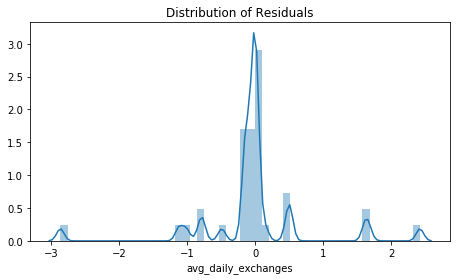

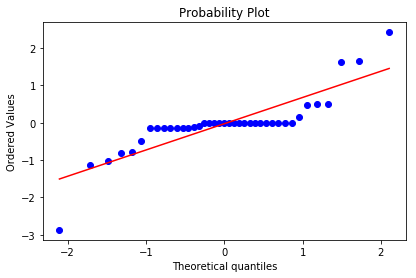

In [11]:
choose_model(tree, 'ALL')

### Get coefficients for linear, lasso, ridge, or elastice net models

In [12]:
# # Get model coefficients 
# coefs = list(zip(X_train.columns, lr.coef_))
# pd.DataFrame(coefs, columns=['Feature','Coef']).sort_values(by='Coef', ascending=False)

### Decision Tree Visualization

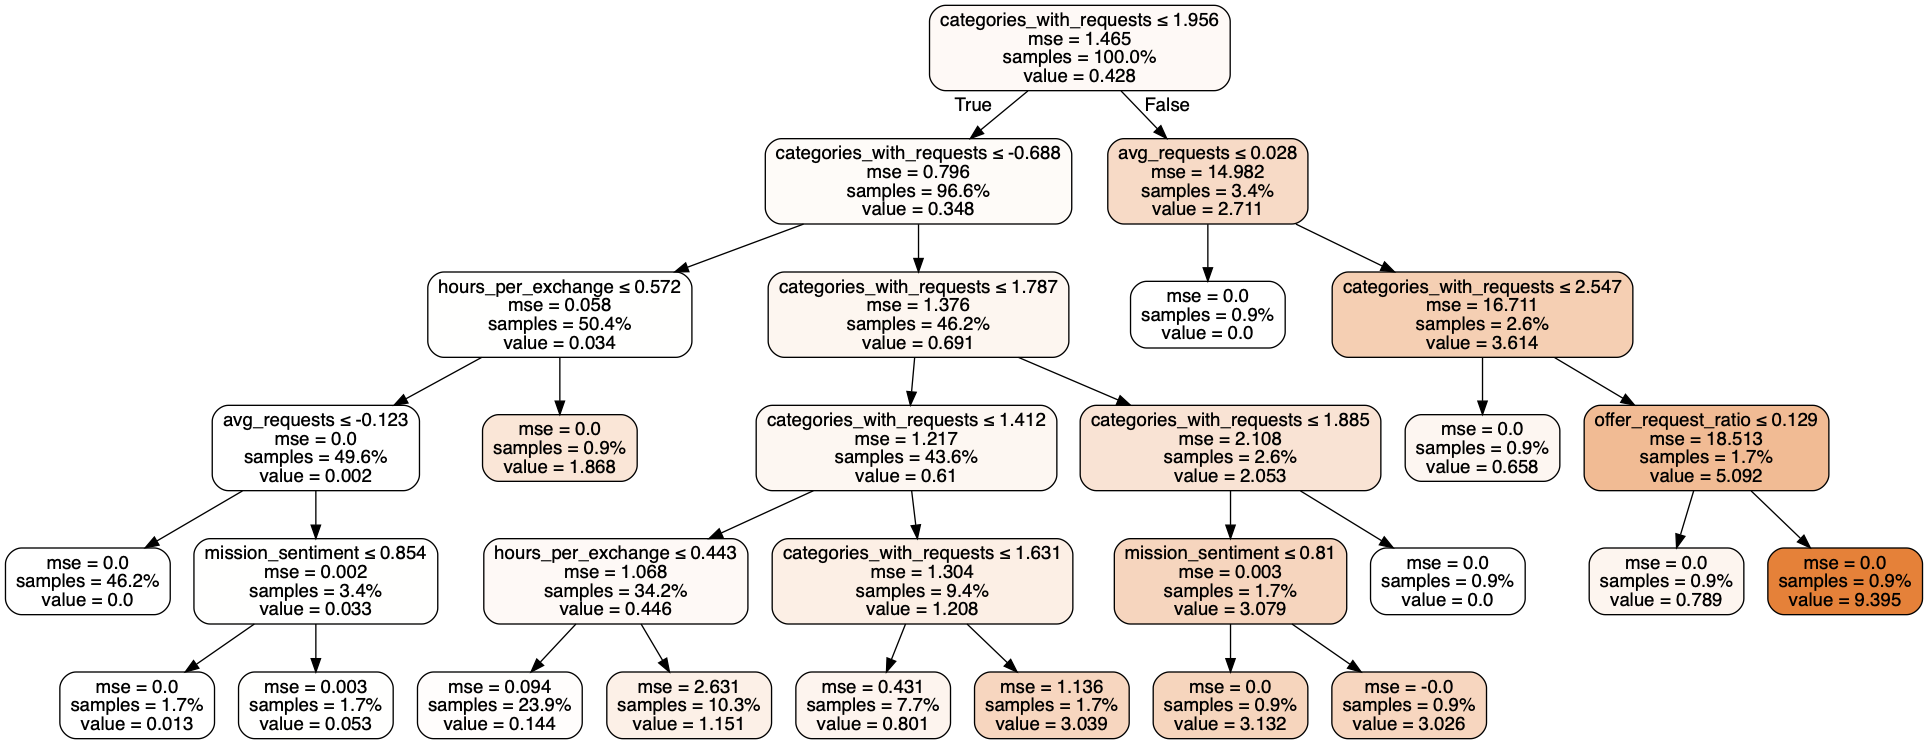

In [13]:
dot_data = StringIO()  

export_graphviz(
    tree, 
    out_file = dot_data,  
    filled=True, rounded=True, proportion=True,  # Set `proportion=False` to see number of records instead
    special_characters=True, 
    feature_names=X_train_sc.columns,
)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### OLS Model
This will return results equivalent to the selected `LinearRegression()` model, but with additional information.

In [14]:
ols = sm.OLS(y_train, X_train_sc).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     avg_daily_exchanges   R-squared:                       0.412
Model:                             OLS   Adj. R-squared:                  0.363
Method:                  Least Squares   F-statistic:                     8.346
Date:                 Sun, 03 Mar 2019   Prob (F-statistic):           2.42e-09
Time:                         19:41:16   Log-Likelihood:                -157.24
No. Observations:                  117   AIC:                             334.5
Df Residuals:                      107   BIC:                             362.1
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.0453      0.702     -0.065      0.949      -1.436       1.346
phone                        0.4511      0.704      0.641      0.523      -0.945       1.847
facebook                     0.0848      0.221      0.383      0.703      -0.354       0.524
mission_sentiment           -0.0031      0.096     -0.033      0.974      -0.194       0.187
notes_word_count            -0.1777      0.098     -1.809      0.073      -0.372       0.017
hours_per_exchange           0.4271      0.129      3.319      0.001       0.172       0.682
avg_offers                 -39.7741      8.694     -4.575      0.000     -57.010     -22.538
avg_requests                39.7302      8.699      4.567      0.000      22.485      56.975
offer_request_ratio          0.1000      0.126      0.791      0.431      -0.151       0.351
categories_with_requests     0.2464      0.131      1.876      0.063      -0.014       0.507
==============================================================================
Omnibus:                      129.072   Durbin-Watson:                   1.805
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3028.698
Skew:                           3.721   Prob(JB):                         0.00
Kurtosis:                      26.788   Cond. No.                         214.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

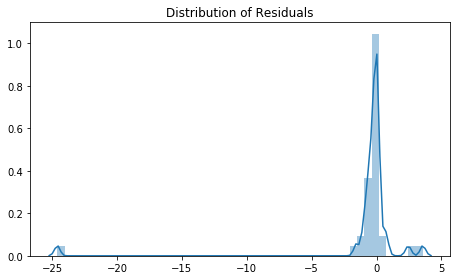

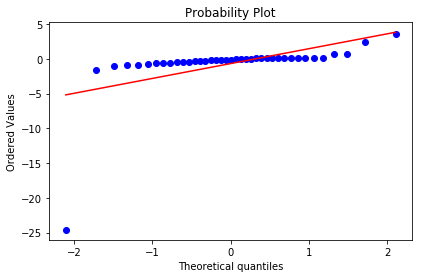

In [15]:
# Get residuals of predictions
pred = ols.predict(X_test_sc)
residuals = y_test - pred

# Create residual plots
plt.figure(1, figsize=(6.5,4))
plt.title('Distribution of Residuals')
sns.distplot(residuals)
plt.tight_layout()

plt.figure(2, figsize=(6.5,4))
stats.probplot(residuals, plot=pylab);

In [16]:
# Get RMSE
print(np.sqrt(mean_squared_error(y_test, pred)))

4.0297470286156996


In [17]:
# Summary of predictions
pred = ols.get_prediction(X_test_sc)
pred.summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
96,0.706969,0.182269,0.345642,1.068297,-1.249861,2.663800
69,0.624268,0.183205,0.261086,0.987451,-1.332905,2.581442
82,0.836363,0.182100,0.475371,1.197355,-1.120405,2.793131
76,-0.081297,0.177521,-0.433211,0.270617,-2.036411,1.873817
114,2.861072,0.484441,1.900725,3.821419,0.711446,5.010699
29,-0.080070,0.156841,-0.390988,0.230848,-2.028222,1.868082
94,0.061982,0.235551,-0.404971,0.528935,-1.917076,2.041041
132,0.755183,0.164439,0.429202,1.081164,-1.195430,2.705796
93,0.290463,0.171976,-0.050460,0.631385,-1.662703,2.243628
139,0.289510,0.157849,-0.023407,0.602427,-1.658963,2.237982
